In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append("../")

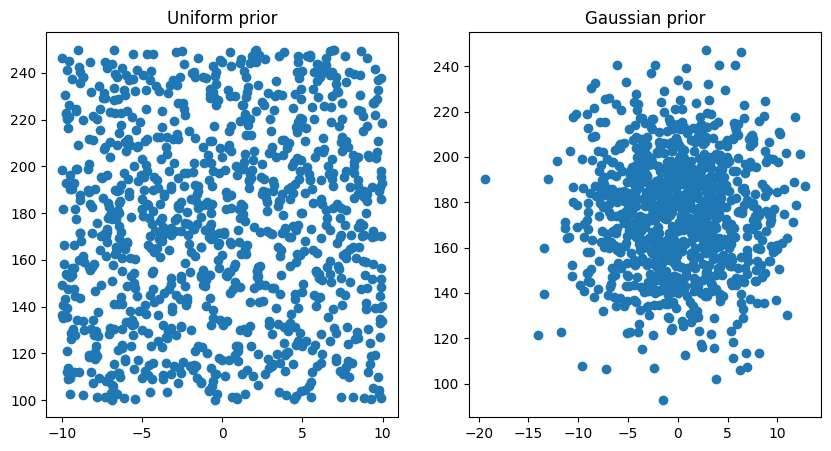

In [3]:
# Prior distributions
from tasks.toy_examples.prior import UniformPrior, GaussianPrior

prior_uniform = UniformPrior()
prior_gaussian = GaussianPrior()

# Plot prior distributions
samples_uniform = prior_uniform.sample((1000,))
samples_gaussian = prior_gaussian.sample((1000,))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(samples_uniform[:, 0], samples_uniform[:, 1])
plt.title("Uniform prior")
plt.subplot(122)
plt.scatter(samples_gaussian[:, 0], samples_gaussian[:, 1])
plt.title("Gaussian prior") 
plt.show()

In [48]:
def euler_sde_sampler(score_fn, nsamples, beta):
    theta_t = torch.randn((nsamples, 2))  # (nsamples, 2)
    time_pts = torch.linspace(1, 0, 1000)  # (ntime_pts,)
    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        f = -0.5 * beta(t) * theta_t
        g = beta(t) ** 0.5
        score = score_fn(theta_t, t).detach()
        drift = f - g * g * score
        diffusion = g

        # euler-maruyama step
        theta_t = theta_t + drift * dt + diffusion * torch.randn_like(theta_t) * torch.abs(dt) ** 0.5
    return theta_t.detach()

In [60]:
# Score functions
from nse import NSE
from vp_diffused_priors import get_vpdiff_uniform_score, get_vpdiff_gaussian_score

nse = NSE(2,2)
diffused_uniform_prior_score = get_vpdiff_uniform_score(prior_uniform.low, prior_uniform.high, nse)
diffused_gaussian_prior_score = get_vpdiff_gaussian_score(prior_gaussian.prior.loc, prior_gaussian.prior.covariance_matrix, nse)

In [61]:
samples_uniform_diffused = euler_sde_sampler(diffused_uniform_prior_score, 1000, nse.beta)
samples_gaussian_diffused = euler_sde_sampler(diffused_gaussian_prior_score, 1000, nse.beta)

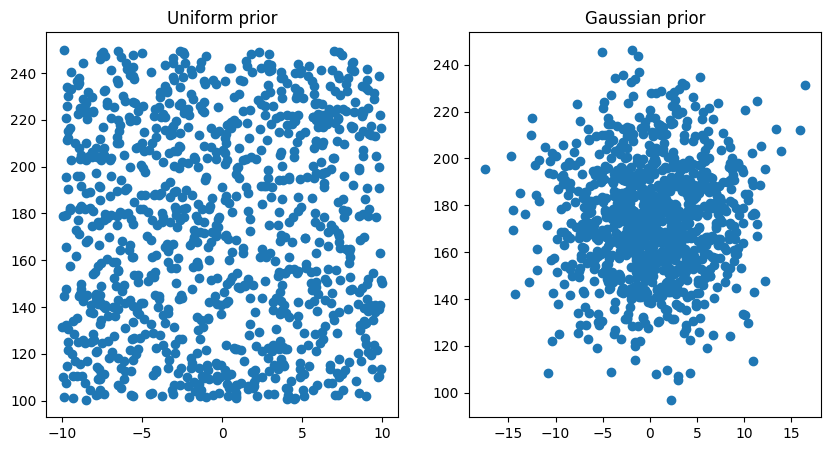

In [62]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(samples_uniform_diffused[:, 0], samples_uniform_diffused[:, 1])
plt.title("Uniform prior")
plt.subplot(122)
plt.scatter(samples_gaussian_diffused[:, 0], samples_gaussian_diffused[:, 1])
plt.title("Gaussian prior")
plt.show()
